In [53]:
from dataclasses import dataclass
from scipy import stats, odr
import matplotlib.pyplot as plt
import numpy as np
from data import DataSeries

# Signals
Signals are used to predict the next hour's price based on historical price data. Signals are provided hourly measurements of price history, and return a boolean value indicating whether the price is expected to increase or decrease the next hour.


# Linear Signal
This signal predicts the next day's price by fitting a linear regression to the price data and extrapolating the next hour's price.
It can be customized to consider a different number of measurements to fit the linear regression.

The signal also checks for correlation strength using the r-value (pearson correlation coefficient) and only triggers if the correlation strength is above a certain threshold.

In [54]:
@dataclass
class LinearSignal:
    measurements_to_consider: int

    def predict_price(self, price_history: DataSeries) -> bool:
        """
        Predicts by fitting a linear regression to the price data and extrapolating the next price.
        """
        x = range(-1 - self.measurements_to_consider, 0)
        y = [price_history[i].price for i in x]

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        return slope > 0 and r_value > 0.2

# Quadratic Signal
This signal predicts the next price by fitting a quadratic regression to the price data and extrapolating.
This should be able to detect recent peaks and troughs in the price data better than the linear signal, and adjust the prediction accordingly.

In [55]:
@dataclass
class QuadraticSignal:
    measurements_to_consider: int

    def predict_price(self, price_history: DataSeries) -> bool:
        """
        Predicts by fitting a quadratic regression to the price data and extrapolating the next price.
        """
        x = range(-1 - self.measurements_to_consider, 0)
        y = [price_history[i].price for i in x]

        data = odr.Data(x, y)
        odr_obj = odr.ODR(data, odr.quadratic)
        output = odr_obj.run()
        coeffs = output.beta
        next_price = coeffs[2]

        return next_price > price_history[-1].price

# Testing the signal
Signals are back-tested using the `test_signal` function, which simulates the signal on historical ETH data.
Data is imported from a csv file containing hourly records of ETH price action over the past few months.
The signal is used to change the leverage of the portfolio between 1x and 0.5x based on the signal's prediction.

A more refined approach could be used in the future to optimize the leverage based on the signal's confidence level.

In [56]:
data = DataSeries.from_csv('resources/eth-usd-hourly.csv')[-365 * 24:]  # only use data from the past year

HISTORY_LENGTH = 24

def test_signal(predictor, name='Investment Strategy', plot_price=True, plot_normalized=False):
    num_correct = 0
    num_true = 0

    eth_prices = np.array([entry.price for entry in data])
    t = np.arange(len(data), dtype=int)
    portfolio = np.zeros_like(t, dtype=float)
    portfolio[0:HISTORY_LENGTH] = data[0:HISTORY_LENGTH].price  # first week doesn't count

    leverage = 1

    # leverage changes
    increase_leverage = [0]
    decrease_leverage = []

    for i in range(HISTORY_LENGTH, len(data) - 1):
        history = data[i - HISTORY_LENGTH:i + 1]
        prediction = predictor.predict_price(history)

        yesterday = eth_prices[i - 1]
        today = eth_prices[i]

        price_change = today - yesterday
        yesterday_portfolio = portfolio[i - 1]
        num_eth = yesterday_portfolio / yesterday
        portfolio[i] = yesterday_portfolio + (num_eth * price_change * leverage)

        tomorrow = eth_prices[i + 1]
        actual_result = tomorrow > today

        if prediction:
            if leverage != 1:
                increase_leverage.append(i)
            leverage = 1
        else:
            if leverage != 0.5:
                decrease_leverage.append(i)
            leverage = 0.5

        if prediction:
            num_true += 1

        if actual_result == prediction:
            num_correct += 1

    increase_leverage.append(len(data) - 1)
    decrease_leverage.append(len(data) - 1)

    if plot_price:
        plt.figure()
        plt.title(name)
        plt.xlabel('Hours Passed')
        plt.ylabel('Value ($)')
        plt.plot(t, eth_prices, label='Eth Price')
        plt.plot(t[HISTORY_LENGTH:len(data) - 1], portfolio[HISTORY_LENGTH:len(data) - 1], label='Portfolio Value')
        for start, end in zip(increase_leverage, decrease_leverage):
            plt.axvspan(start, end, color='g', alpha=0.2)
        for start, end in zip(decrease_leverage, increase_leverage[1:]):
            plt.axvspan(start, end, color='r', alpha=0.2)
        plt.legend(loc='upper left')
        plt.show()

    if plot_normalized:
        plt.figure()
        plt.title(name)
        plt.xlabel('Hours Passed')
        plt.ylabel('Value (ETH)')
        plt.plot(t, eth_prices / eth_prices, label='Eth Price')
        plt.plot(t[HISTORY_LENGTH:len(data) - 1], (portfolio / eth_prices)[HISTORY_LENGTH:len(data) - 1], label='Portfolio Value')
        for start, end in zip(increase_leverage, decrease_leverage):
            plt.axvspan(start, end, color='g', alpha=0.2)
        for start, end in zip(decrease_leverage, increase_leverage[1:]):
            plt.axvspan(start, end, color='r', alpha=0.2)
        plt.legend(loc='upper left')
        plt.show()

    print(name)
    print(f'Bullish ratio: {num_true / (len(data) - HISTORY_LENGTH - 1)}')
    print(f'Accuracy: {num_correct / (len(data) - HISTORY_LENGTH - 1)}')
    print()

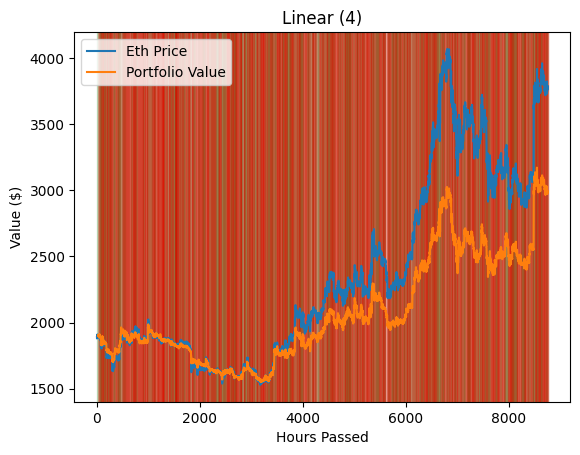

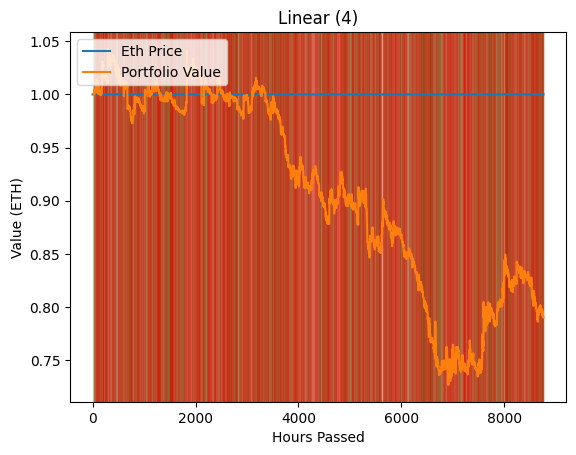

Linear (4)
Bullish ratio: 0.461705781339439
Accuracy: 0.46090440755580997


In [57]:
signal = LinearSignal(4)
test_signal(signal, name=f'Linear ({signal.measurements_to_consider})', plot_price=True, plot_normalized=True)

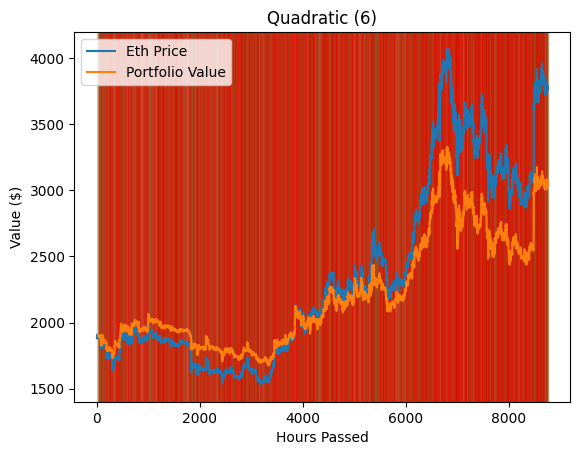

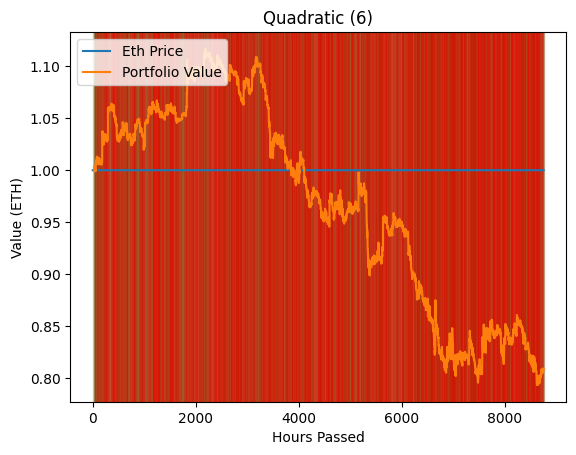

Quadratic (6)
Bullish ratio: 0.5240984544934173
Accuracy: 0.47864911276473954


In [58]:
signal = QuadraticSignal(6)
test_signal(signal, name=f'Quadratic ({signal.measurements_to_consider})', plot_price=True, plot_normalized=True)